In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import scipy
import functools

import scipy

from sklearn import datasets
from sklearn.preprocessing import LabelBinarizer

# Naive Bayes Classifier

Alex Gorodetsky, March 2024

The goals of this notebook are to introduce the (Gaussian) Naive Bayes classifier as an example of how factorization of probability distributions can enable algorithmic efficiency. We learn the classifer using a maximum likelihood approach. This requires no optimization or tuning and provides a closed form expression for the classifier. This notebook is a companion to the multi-class classification notebook that we considered earlier; however the model here is generative rather than discriminative.


## Multi-class classification
Suppose that we have a dataset $D = \left\{(x^{(k)}, y^{(k)})\right\}_{k=1}^N$, were $x^{(k)} \in \mathbb{R}^d$ and $y^{(k)} \in \{1,2,\ldots, n\}$ are discrete valued out of $n$ possible choices. Our goal is to predict the class of other potential inputs $x \in \mathbb{R}^{d}$.  To make this concrete lets take a look at some sample dataset. 

We will use [scikit-learn](https://scikit-learn.org/stable/index.html) to generate some data from the "Iris" dataset, which has three classes

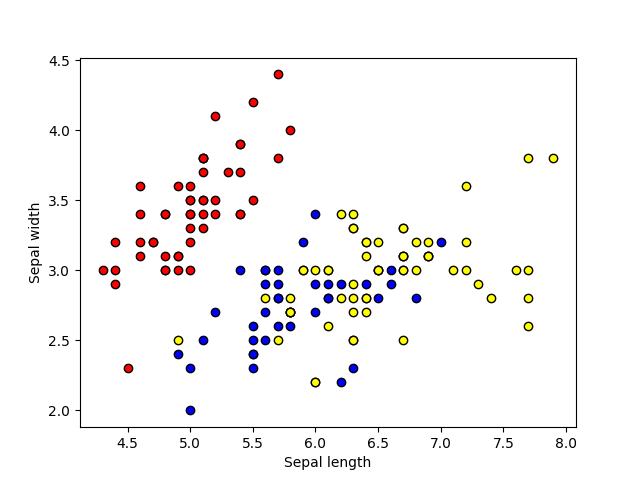

In [2]:

iris = datasets.load_iris()
X = iris.data[:, :2] # just take first two features
y = iris.target + 1 # add 1 so that targets are ordinal numbers

# colordict = {0: 'darkviolet', 1: 'darkgoldenrod', 2: 'olive'}
colordict = {0: 'red', 1: 'blue', 2: 'yellow'}
plt.close(1)
plt.figure(1)
for ii in range(3):
    inds = y==(ii+1)
    plt.scatter(X[inds, 0], X[inds, 1], c=colordict[ii], edgecolor="k", label=iris.target_names[ii])
plt.xlabel("Sepal length")
plt.ylabel("Sepal width")
plt.show()

### The sampling distribution

The Naive Bayes classifier uses a generative probabilistic approach for classification. Consider that it seeks a posterior distribution for the class given in the input feature

\begin{equation}
p(y \mid x) = \frac{p(x \mid y) p(y)}{p(x)} = \frac{p(x,y)}{p(x)}
\end{equation}
Here we have used the definition of conditional expectation to write the target posterior distribution as a function of the *joint distribution of inputs and the class.* Thus, as opposed to the discriminative classifier we studied previously, this model also consider the mechanism by which the dependent variables arise. 

Next consider that the features can be $d$ dimensional $x = (x_1, \ldots, x_d)$. The Naive Bayes classifer makes the following conditional independence assumption

$$
x_{i} \perp x_{j} \mid y \quad \forall i,j $$

This conditional independence assumption yields the factorization

\begin{equation}
p(x, y) = p(y) \prod_{i=1}^d p(x_{i} \mid y)
\end{equation}

so that the prediction of a given class given an input becomes

\begin{equation}
p(y = j \mid x) \propto p_j \prod_{i=1}^d p_j(x_{i})
\end{equation}
where $p_j = p(y = j)$ and $p_j(x_{i}) = p(x_{i} \mid y = j)$

Now the things that are unknown here are the prior $p_j$ for $(j=1,\ldots,n)$, and the conditionals $p_j(x_{i})$. The prior is a distribution over a finite discrete set of possibilities and the second one is typically parameterized in some family; e.g., a Gaussian one

\begin{equation}
p_j(x_{i}) \sim \mathcal{N}(\mu_{ij}, \sigma_{ij}^2)
\end{equation}

Thus the unknown parameters are $\theta = \{p_1, \ldots, p_n, \mu_{11},\sigma^2_{11}, \ldots\}$

We will estimate these parameters via maximum likelihood estimation. To form the likelihood we have 

$$
p(\{x^{(k)}, y^{(k)}\}_{k=1}^N \mid \theta) = \prod_{\ell=1}^N p(y^{(\ell)}) \prod_{i=1}^d p(x^{(k)}_{i} \mid y^{(\ell)})
$$

The solution is analytic by noting that you can group all the sums into groups for each class and each feature. The analytic solution is

\begin{equation}
p_{j} = \frac{\text{\# of times class $j$ appears}}{N}
\end{equation}

Similarly, the means and variances of the Gaussian are the corresponding sample means and variances

$$\mu_{ij} = \frac{1}{n_j} \sum_{k=1}^{N} \mathbf{1}_{j}(y^{(k)}) x^{(k)}_i $$
and 


$$
\sigma_{ij}^2 = \frac{1}{n_j-1} \sum_{k=1}^{N} \mathbf{1}_{j}(y^{(k)}) \left( x^{(k)}_i - \mu_{ij} \right)^2
$$
where $n_{j}$ is the number of times class $j$ appears.

In [3]:
class GaussianNaiveBayes:

    def __init__(self, num_classes):
        self.num_classes = num_classes

    def train(self, x, y):
        """Train the Naive Bayes Classifier.

        Args:
        x: (N, d) features
        y: (N) labels
        """
        self.dim = x.shape[1]
        N = x.shape[0]
        self.class_probs = np.zeros(self.num_classes)
        self.means = np.zeros((self.dim, self.num_classes))
        self.vars = np.zeros((self.dim, self.num_classes))

        for ii in range(self.num_classes):
            data = x[y == ii+1, :]
            self.means[:, ii] = np.mean(data, axis=0)
            self.vars[:, ii] = np.var(data, axis=0)
            self.class_probs[ii] = float(np.sum(y == ii+1) / float(N))

    def predict(self, x):
        N = x.shape[0]
        probs = np.zeros((N, self.num_classes))
        for ii in range(self.num_classes):
            pre = -0.5 * np.log(2 * np.pi)
            for jj in range(self.dim):
                pre = pre - 0.5 * np.log(self.vars[jj, ii])
                pre = pre - 0.5 * (x[:, jj] - self.means[jj, ii])**2 / self.vars[jj, ii]
            probs[:, ii] = np.exp(pre)

        class_predict = np.argmax(probs, axis=1)
        return class_predict

We are now ready to run our algorithms!

## Predictions

We now train and predict with our model

In [4]:
nb = GaussianNaiveBayes(3)
nb.train(X, y)
print("Class probability = ", nb.class_probs)
print("Means = ", nb.means)
print("Vars = ", nb.vars)

Class probability =  [0.33333333 0.33333333 0.33333333]
Means =  [[5.006 5.936 6.588]
 [3.428 2.77  2.974]]
Vars =  [[0.121764 0.261104 0.396256]
 [0.140816 0.0965   0.101924]]


Lets visualize the predictor.

In [5]:
def visualize_predictor(fignum, predictor):
    N = 60
    M = 50

    xmin = np.min(X[:, 0])
    xmax = np.max(X[:, 0])
    ymin = np.min(X[:, 1])
    ymax = np.max(X[:, 1])
    x = np.linspace(xmin, xmax, N)
    ylin = np.linspace(ymin, ymax, M)
    xx, yy = np.meshgrid(x, ylin)
    xy = np.array([xx.flatten(), yy.flatten()]).T  # this is now a NN x 2 array
    p = predictor.predict(xy)

    plt.figure(fignum)
    plt.contourf(xx, yy, p.reshape((M, N)), alpha=0.8)
    plt.colorbar()
    for ii in range(3):
        inds = y==(ii+1)
        plt.scatter(X[inds, 0], X[inds, 1], c=colordict[ii], edgecolor="k", label=iris.target_names[ii])
    plt.title("Most Likely")

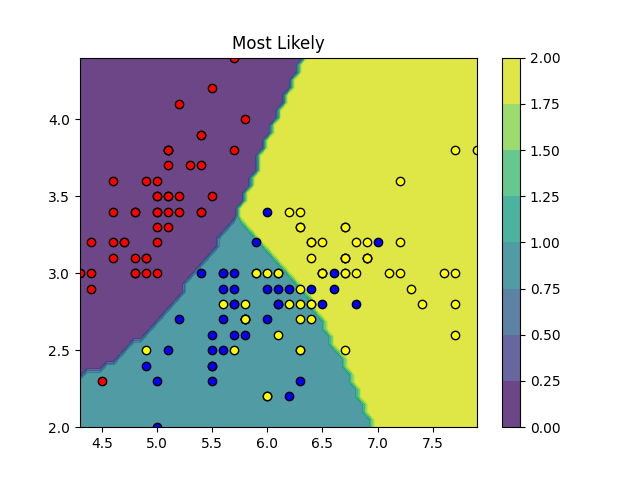

In [6]:
plt.close(2)
plt.close(2)
visualize_predictor(2, nb)
plt.show()